In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Main Data

In [3]:
path = '/Users/aleksandr/hackaton/clean_source.xlsx'
dataBase = pd.read_excel(path)

In [4]:
dataBase.head()

n_user  age gender  height  weight  pulse  bp_upper  bp_lower  n_exp  ODI  \
0       1   51      M     164    60.0     80        95        60      1  0.0   
1       1   51      M     164    60.0     80        95        60      2  0.3   
2       2   22      M     174    66.0     50       110        70      1  0.2   
3       2   22      M     174    66.0     50       110        70      2  0.2   
4       3   41      F     164    53.0    100       120        80      1  0.4   

   target  class  num_apnee  num_hypeapnea   AI   HI  AHI  
0       0      0          0              0  0.0  0.0  0.0  
1       0      0          0              0  0.0  0.0  0.0  
2       0      0          0              0  0.0  0.0  0.0  
3       0      0          0              0  0.0  0.0  0.0  
4       0      0          0              0  0.0  0.0  0.0

In [5]:
# EEG Data

In [6]:
fileList = glob.glob(os.getcwd()+ '/allPickleDataDir/*.pkl')

rawList = []
for file in tqdm(fileList):
    with open(file, 'rb') as f:
        x = pickle.load(f)
        rawList.append(x[0])

dataRaw = pd.DataFrame(rawList).rename(columns={"user": "n_user", "exp": "n_exp", "values": "signal"})
dataShort = dataRaw[['n_user', 'type', 'n_exp', 'signal']]
dataShort['n_user'] = dataShort['n_user'].apply(lambda x: int(str(x).replace("Np ", "")))
dataShort['n_exp'] = dataShort['n_exp'].apply(lambda x: int(str(x).replace("Nr ", "")))
dataShort['type'] = dataShort['type'].apply(lambda x: str(x).replace("_o1-m2", "1"))
dataShort['type'] = dataShort['type'].apply(lambda x: str(x).replace("_o2-m1", "2"))
dataShort['type'] = dataShort['type'].astype('int')
dataTargets = dataShort.merge(dataBase, how='left', on = ['n_user', 'n_exp'])

100%|██████████| 155/155 [00:12<00:00, 12.42it/s]


In [7]:
dataTargets.head()

n_user  type  n_exp                                             signal  \
0       6     1      1  [-35, -37, -34, -34, -33, -30, -30, -28, -25, ...   
1       7     1      1  [0, -1, -1, 0, 0, -1, -1, -1, 0, -2, -2, 0, -2...   
2      37     2      2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3      36     2      2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4      14     1      1  [7, 7, 7, 11, 8, 10, 6, 7, 8, 6, 1, 1, 1, -2, ...   

   age gender  height  weight  pulse  bp_upper  bp_lower   ODI  target  class  \
0   29      M     187    91.0     76        90        60   0.2       0      0   
1   50      M     165    60.0     84       130        90   0.3       0      0   
2   52      M     180   120.0     90       180        80   0.0       1      3   
3   29      M     173   121.0     76       120        80  29.6       1      3   
4   81      F     158    88.0     84       150        84   0.0       0      0   

   num_apnee  num_hypeapnea     AI    HI    AHI  
0          0              0    0.0   0.0    0.0  
1          0              0    0.0   0.0    0.0  
2        668             97   80.3  12.0   92.0  
3        789             61  116.0   9.0  125.0  
4          0              0    0.0   0.0    0.0

# create features

In [10]:
def calcSetmetrics(signalList):
    minValue = np.min(signalList)
    maxValue = np.max(signalList)
    meanValue = np.mean(signalList)
    stdValue = np.std(signalList)
    q1 = np.quantile(signalList, 0.001)
    q2 = np.quantile(signalList, 0.01)
    q3 = np.quantile(signalList, 0.05)
    q4 = np.quantile(signalList, 0.95)
    q5 = np.quantile(signalList, 0.99)
    q6 = np.quantile(signalList, 0.999)
    outlierCount = np.array([np.abs(i-meanValue) >= 3*stdValue for i in signalList]).sum()
    outlierShare = np.array([np.abs(i-meanValue) >= 3*stdValue for i in signalList]).mean()
    
    return [minValue, maxValue, meanValue, stdValue, q1, q2, q3, q4, q5, q6, outlierCount, outlierShare]

In [14]:
preprocessDataList = []
for index, row in tqdm(dataTargets.iterrows()):
    signalList = row['signal'][10*60*200:-3*60*200]
    sleepDurationSeconds = len(signalList) / 200
    
    # Inital Data
    listInitalOverall = calcSetmetrics(signalList) ## Overall
    listInitalFirstThird = calcSetmetrics(signalList[(len(signalList) // 3) * 0: (len(signalList) // 3) * 1]) ## First third
    listInitalSecondThird = calcSetmetrics(signalList[(len(signalList) // 3) * 1: (len(signalList) // 3) * 2]) ## Second third
    listInitalThirdThird = calcSetmetrics(signalList[(len(signalList) // 3) * 2:]) ## Third third
    
    # Smooth Data
    stepSizeHundred = len(signalList) // 100
    signalListParted = []
    for i in range(100):
        signalListParted.append(np.mean(signalList[stepSizeHundred*i:stepSizeHundred*(i+1)] if i < 99 else signalList[stepSizeHundred*i:]))
    
    listSmoothOverall = calcSetmetrics(signalListParted) ## Overall
    listSmoothFirstThird = calcSetmetrics(signalListParted[(len(signalListParted) // 3) * 0: (len(signalListParted) // 3) * 1]) ## First third
    listSmoothSecondThird = calcSetmetrics(signalListParted[(len(signalListParted) // 3) * 1: (len(signalListParted) // 3) * 2]) ## Second third
    listSmoothThirdThird = calcSetmetrics(signalListParted[(len(signalListParted) // 3) * 2:]) ## Third third
    
    
    preprocessDataList.append([
        row['n_user'], row['type'], row['n_exp'], sleepDurationSeconds, 
        *listInitalOverall, *listInitalFirstThird, *listInitalSecondThird, *listInitalThirdThird,
        *listSmoothOverall, *listSmoothFirstThird, *listSmoothSecondThird, *listSmoothThirdThird
    ])

155it [36:38, 14.19s/it]


In [16]:
with open('preprocessedData.pkl', 'wb') as f:
    pickle.dump(preprocessDataList, f)

In [37]:
dataPreFinal = (
    dataTargets
        .drop('signal', axis=1)
        .merge(
            pd.DataFrame(
            preprocessDataList, 
            columns=['n_user', 'n_exp', 'type', 'feat_1', *[f'feat_{i+2}' for i in range(len(preprocessDataList[0]) - 4)]]
            ),
            how='left',
            on=['n_user', 'n_exp', 'type']
        )
)

In [45]:
dataPreFinalType1 = dataPreFinal.query("type == 1")
dataPreFinalType2 = dataPreFinal.query("type == 2")[['n_user', 'n_exp', *[i for i in dataPreFinal.columns if 'feat_' in i]]]
dataPreFinalType2.columns = ['n_user', 'n_exp', *[f'feat_{97+i}' for i in range(1, 98)]]
dataFinal = dataPreFinalType1.merge(dataPreFinalType2, how='inner', on=['n_user', 'n_exp'])

In [53]:
dataFinal.to_parquet('data_final.parquet')

In [56]:
dataFinal.head(1)

n_user  type  n_exp  age gender  height  weight  pulse  bp_upper  bp_lower  \
0       6     1      1   29      M     187    91.0     76        90        60   

   ...  feat_185  feat_186  feat_187  feat_188  feat_189  feat_190  feat_191  \
0  ...  0.216007  0.308568 -0.960815 -0.674214  0.003294  0.361106  1.103183   

   feat_192  feat_193  feat_194  
0  1.430704       2.0  0.058824  

[1 rows x 212 columns]

# Raw Visual Analysis

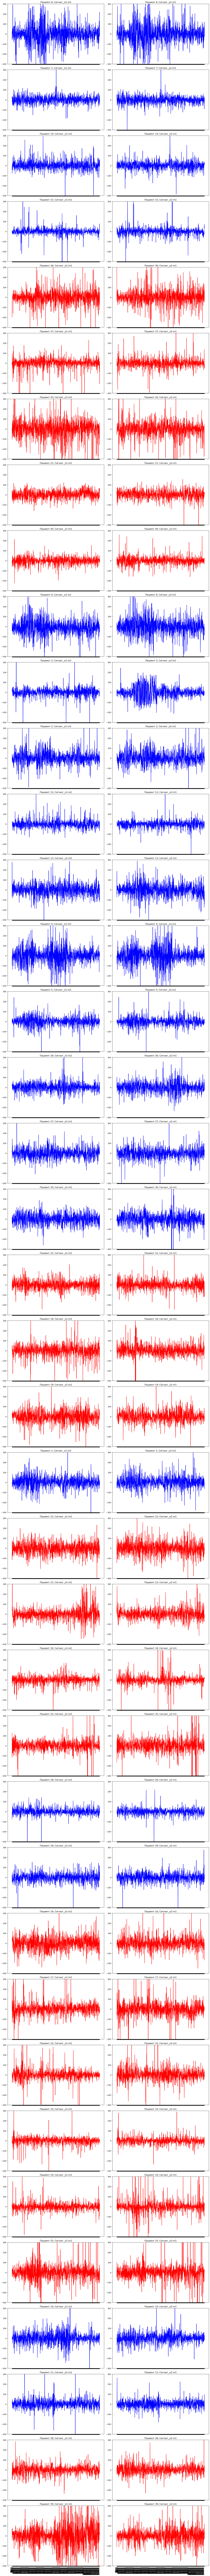

In [22]:
#Визуализируем фрагменты с проявлением синдрома и без
def visualizate_signals(data, start, end, step):
    
    userList = list(data.n_user.unique())
    typeList = list(data.type.unique())
    
    nrows=len(userList)
    ncols=len(typeList)
    
    width_per_graph = 8
    height_per_graph = 5
    fig_width = ncols * width_per_graph
    fig_height = nrows * height_per_graph
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))
    fig.autofmt_xdate(rotation=90)
    
    for r in range(nrows):
        for c in range(ncols):
            
            dataPatient = data.loc[data['n_user'].isin([userList[r]]) & data['type'].isin([typeList[c]])].iloc[0]
            if dataPatient.target == 1:
                colorLine = 'red'
            else:
                colorLine = 'blue'
                
            ys = dataPatient.signal[start:end:step]
            xs = [str((start+step*x)/200) for x in range(len(ys))]
            
            axes[r, c].plot(xs, ys, color = colorLine)
            axes[r, c].set_title(f'Пациент {userList[r]}; Сигнал {typeList[c]}')
            axes[r, c].set_ylim([-300, 300])

    # Отображение графиков
    
    plt.tight_layout()
    plt.show()
    
visualizate_signals(dataTargets.query("n_exp == 1"), 150000, 2400000, 2000)

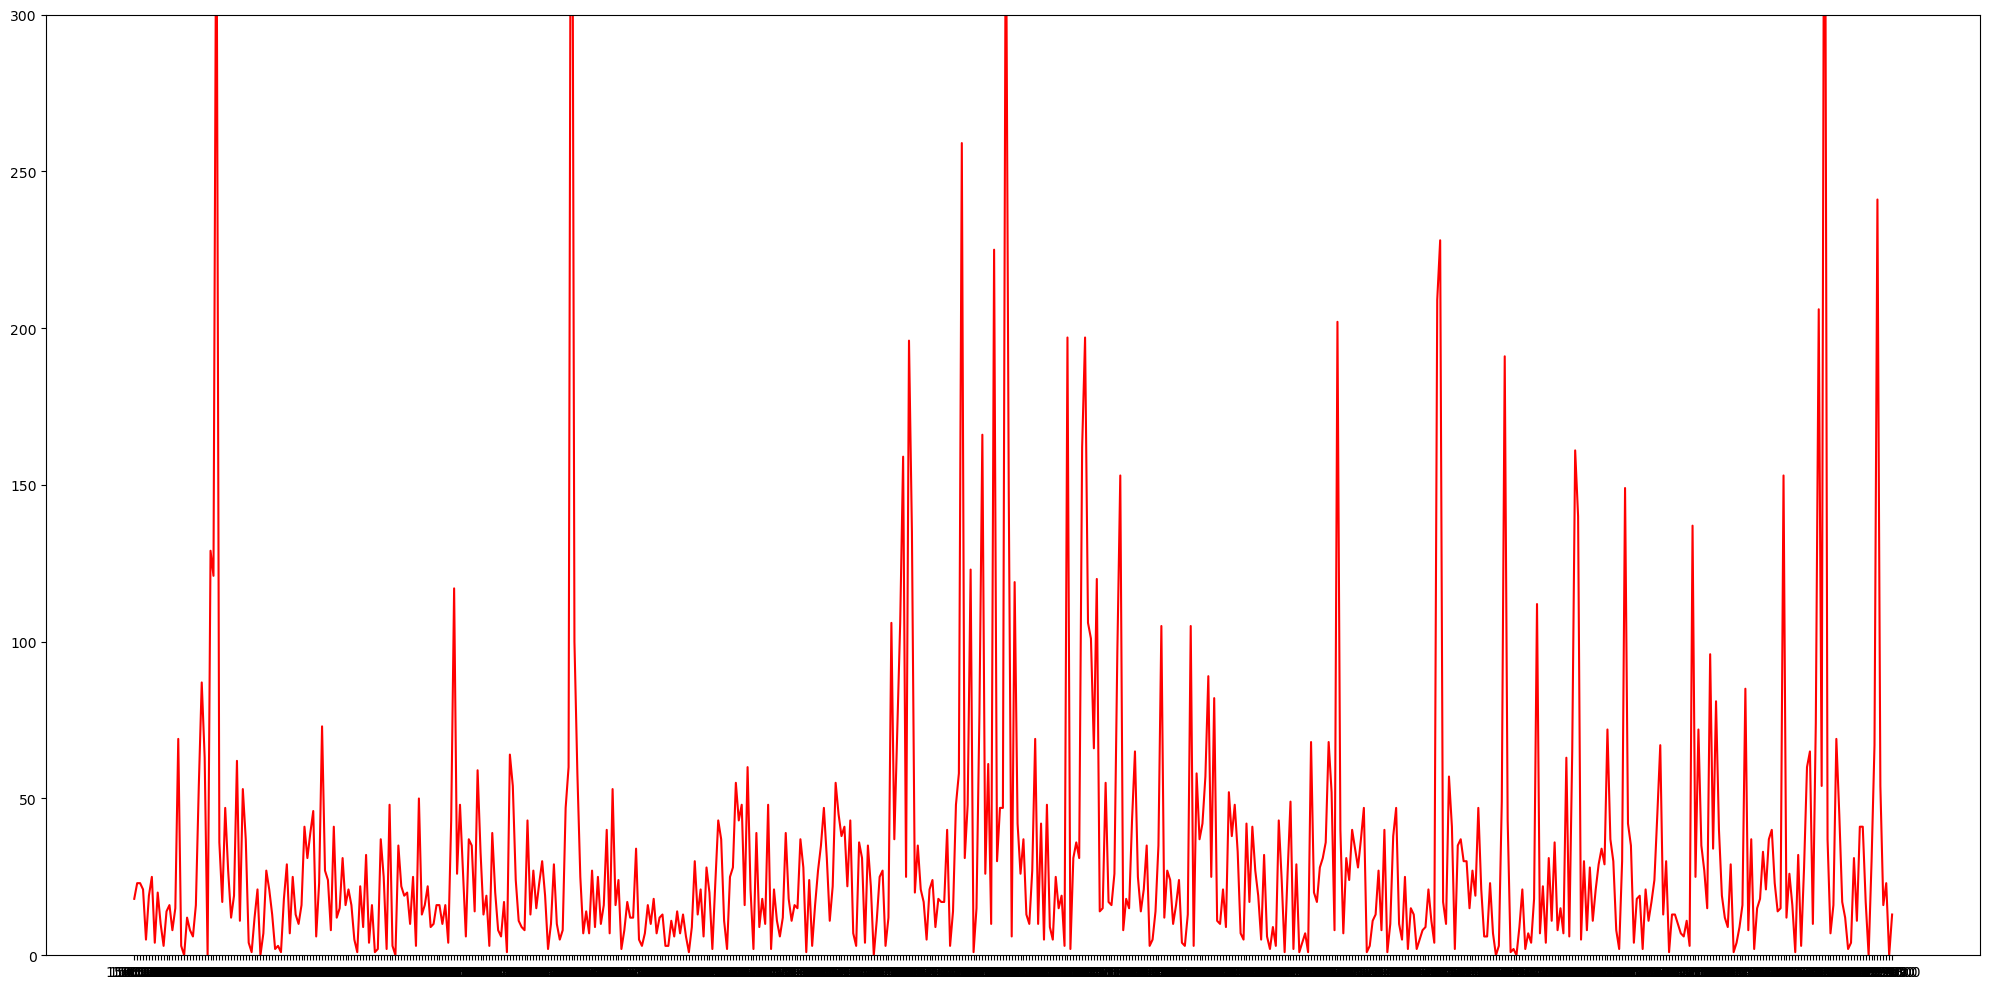

In [8]:
dataPatient = dataTargets.loc[dataTargets['n_user'].isin([37]) & dataTargets['type'].isin([1]) & dataTargets['n_exp'].isin([1])].iloc[0]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

start = 3_000_000
end = 3_000_000 + 10 * 60 * 200
step = 200

if dataPatient.target == 1:
    colorLine = 'red'
else:
    colorLine = 'blue'
                
ys = np.abs(dataPatient.signal[start:end:step])
xs = [str((start+step*x)/200) for x in range(len(ys))]
            
plt.plot(xs, ys, color=colorLine)
axes.set_ylim([0, 300])
# Отображение графиков
plt.tight_layout()
plt.show()

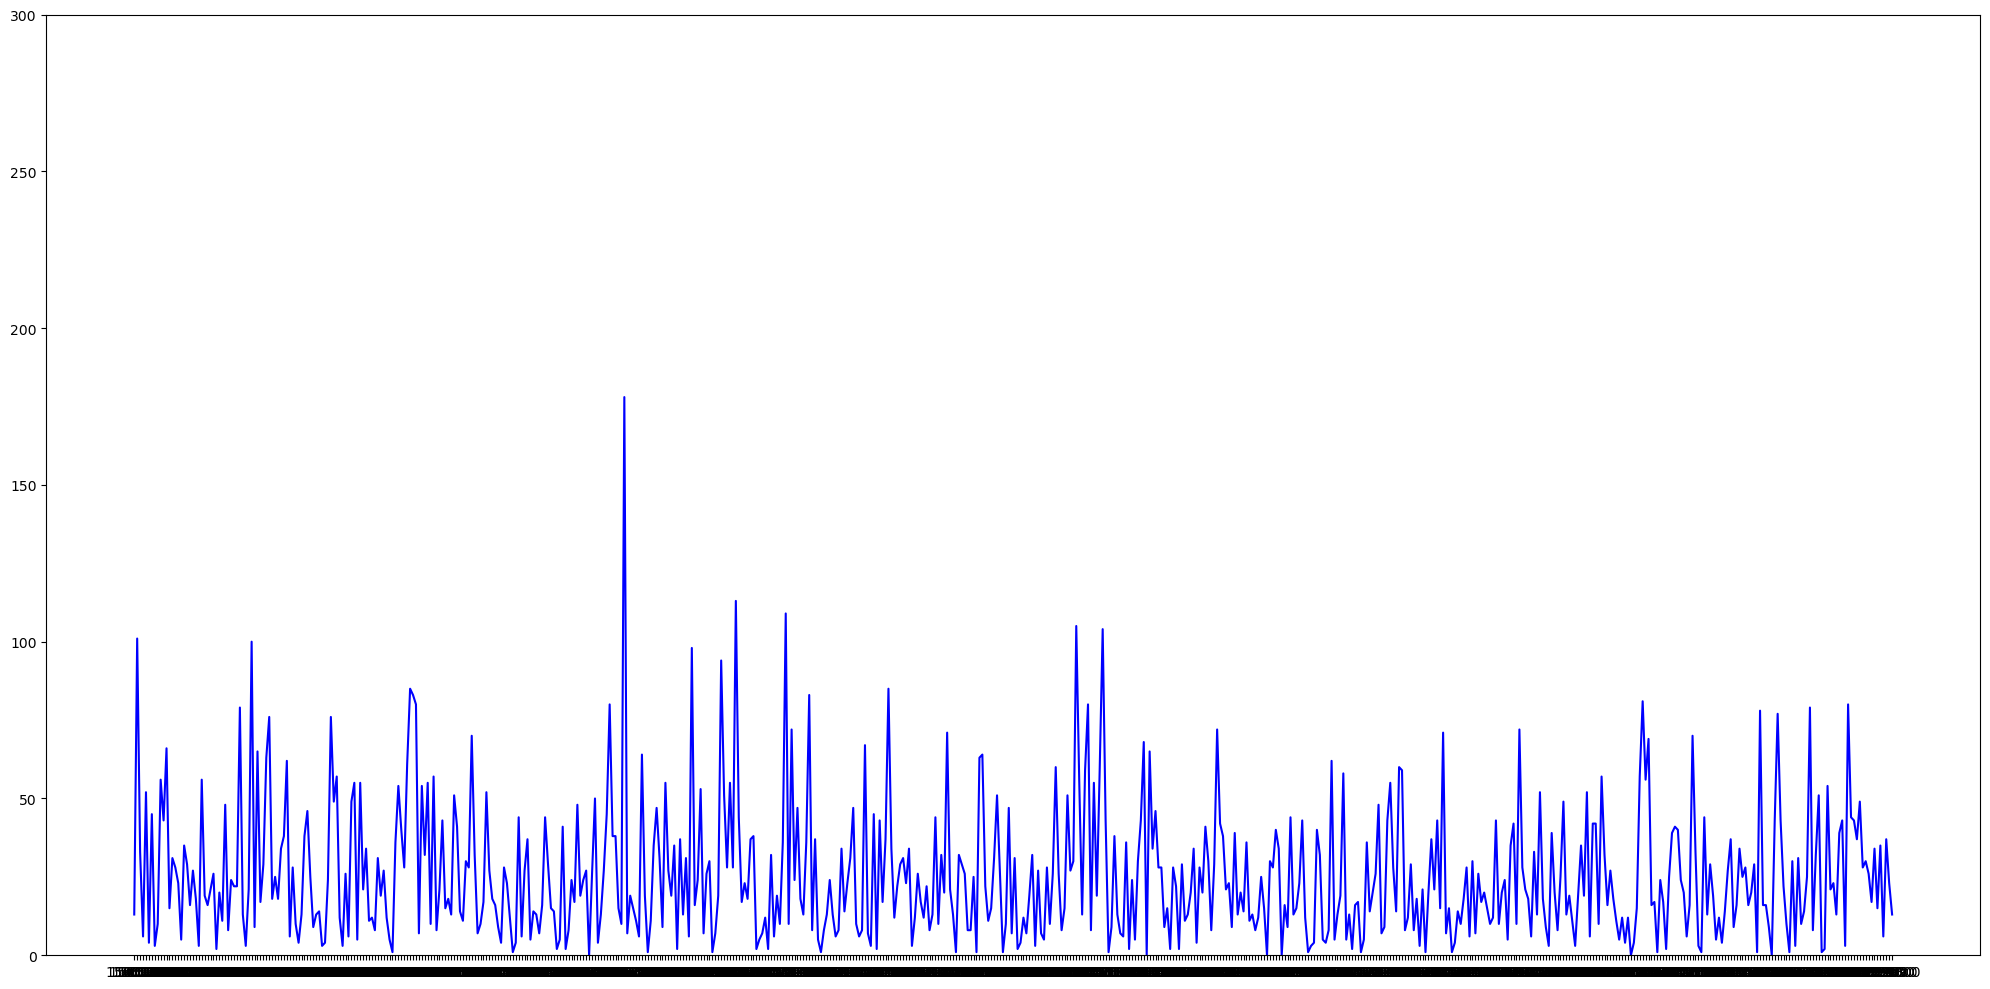

In [9]:
dataPatient = dataTargets.loc[dataTargets['n_user'].isin([7]) & dataTargets['type'].isin([1]) & dataTargets['n_exp'].isin([1])].iloc[0]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

start = 3_000_000
end = 3_000_000 + 10 * 60 * 200
step = 200

if dataPatient.target == 1:
    colorLine = 'red'
else:
    colorLine = 'blue'
                
ys = np.abs(dataPatient.signal[start:end:step])
xs = [str((start+step*x)/200) for x in range(len(ys))]
            
plt.plot(xs, ys, color=colorLine)
axes.set_ylim([0, 300])
# Отображение графиков
plt.tight_layout()
plt.show()

100%|██████████| 39/39 [00:17<00:00,  2.22it/s]


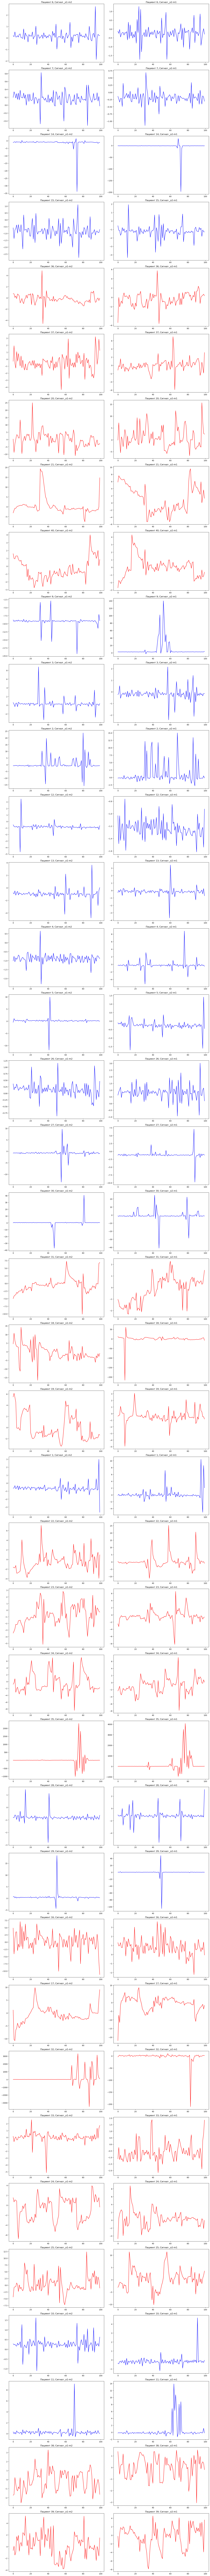

In [64]:
#Визуализируем фрагменты с проявлением синдрома и без
def visualizate_signals(data):
    
    userList = list(data.n_user.unique())
    typeList = list(data.type.unique())
    
    nrows=len(userList)
    ncols=len(typeList)
    
    width_per_graph = 8
    height_per_graph = 5
    fig_width = ncols * width_per_graph
    fig_height = nrows * height_per_graph
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))
    
    for r in tqdm(range(nrows)):
        for c in range(ncols):
            
            dataPatient = data.loc[data['n_user'].isin([userList[r]]) & data['type'].isin([typeList[c]])].iloc[0]
            
            if dataPatient.target == 1:
                colorLine = 'red'
            else:
                colorLine = 'blue'
                
            ysTotal = dataPatient.signal[10*60*200:-3*60*200]
            stepSize = len(ysTotal) // 100
            ys = []
            
            for i in range(100):
                partData = ysTotal[stepSize*i:stepSize*(i+1)] if i < 99 else ysTotal[stepSize*i:]
                ys.append(np.mean(partData))
            xs = [x for x in range(len(ys))]
            
            axes[r, c].plot(xs, ys, color = colorLine)
            axes[r, c].set_title(f'Пациент {userList[r]}; Сигнал {typeList[c]}')
            # axes[r, c].set_ylim([-300, 300])

    # Отображение графиков
    
    plt.tight_layout()
    # plt.savefig('pic1.png')
    plt.show()
    
visualizate_signals(dataTargets.query("n_exp == 1"))

100%|██████████| 50/50 [00:00<00:00, 33624.37it/s]


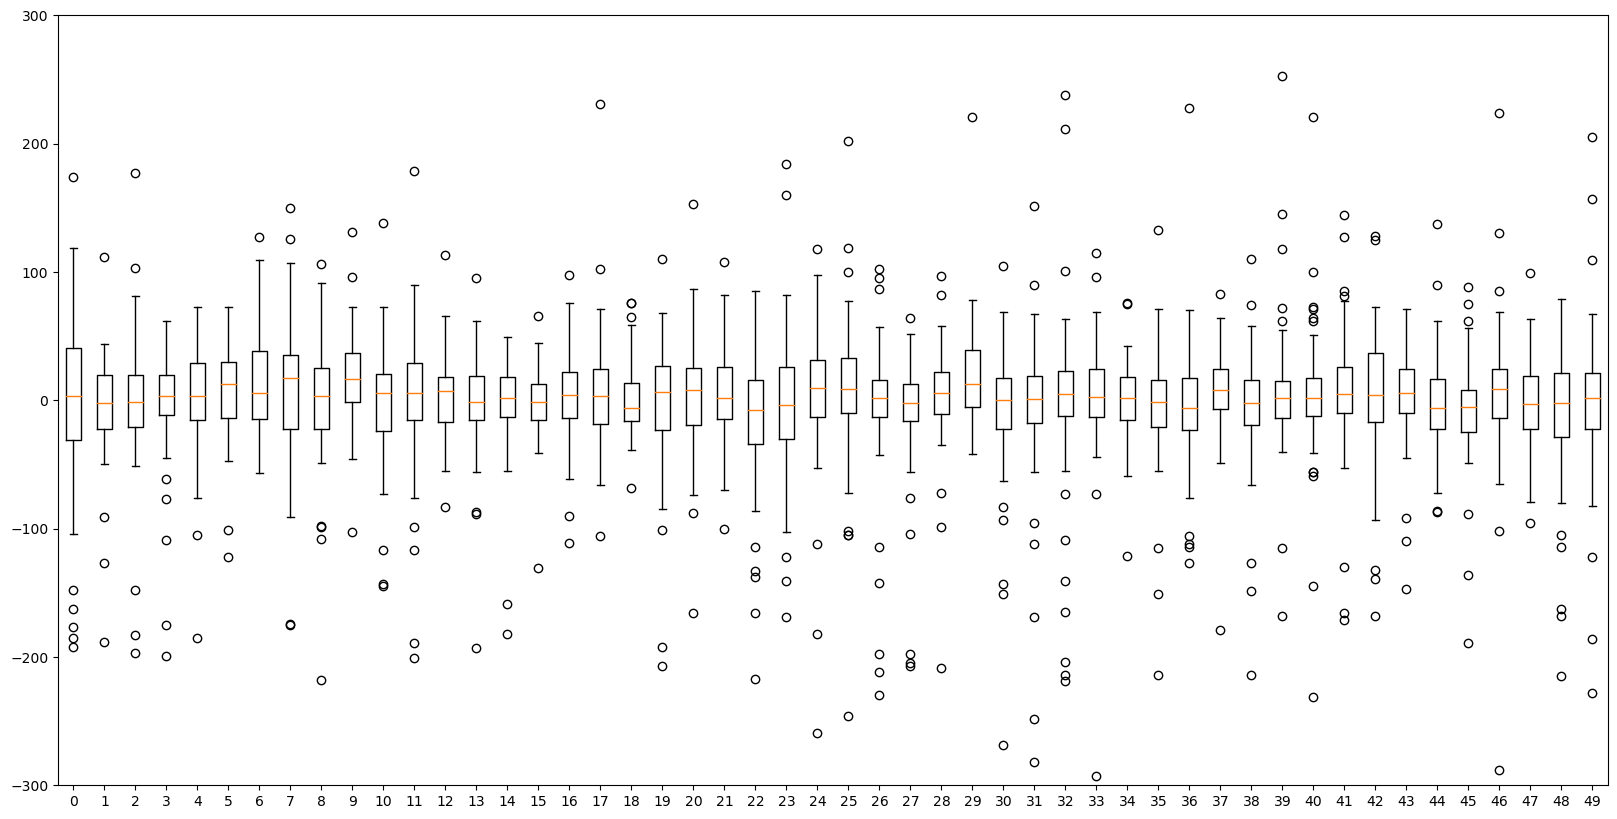

In [48]:
dataPatient = dataTargets.loc[dataTargets['n_user'].isin([37]) & dataTargets['type'].isin([1]) & dataTargets['n_exp'].isin([1])].iloc[0]
fig, ax = plt.subplots()

if dataPatient.target == 1:
    colorLine = 'red'
else:
    colorLine = 'blue'

ysTotal = dataPatient.signal[10*60*200:-3*60*200:2000]
stepSize = len(ysTotal) // 50
ys = []

for i in tqdm(range(50)):
    partData = ysTotal[stepSize*i:stepSize*(i+1)] if i < 49 else ysTotal[stepSize*i:]
    ys.append([j for j in partData if np.abs(j) <= 300])
    
plt.rcParams["figure.figsize"] = (20,10)
ax.set_ylim([-300, 300])
plt.boxplot(ys, positions=range(len(ys)))
plt.show()

100%|██████████| 50/50 [00:00<00:00, 35971.73it/s]


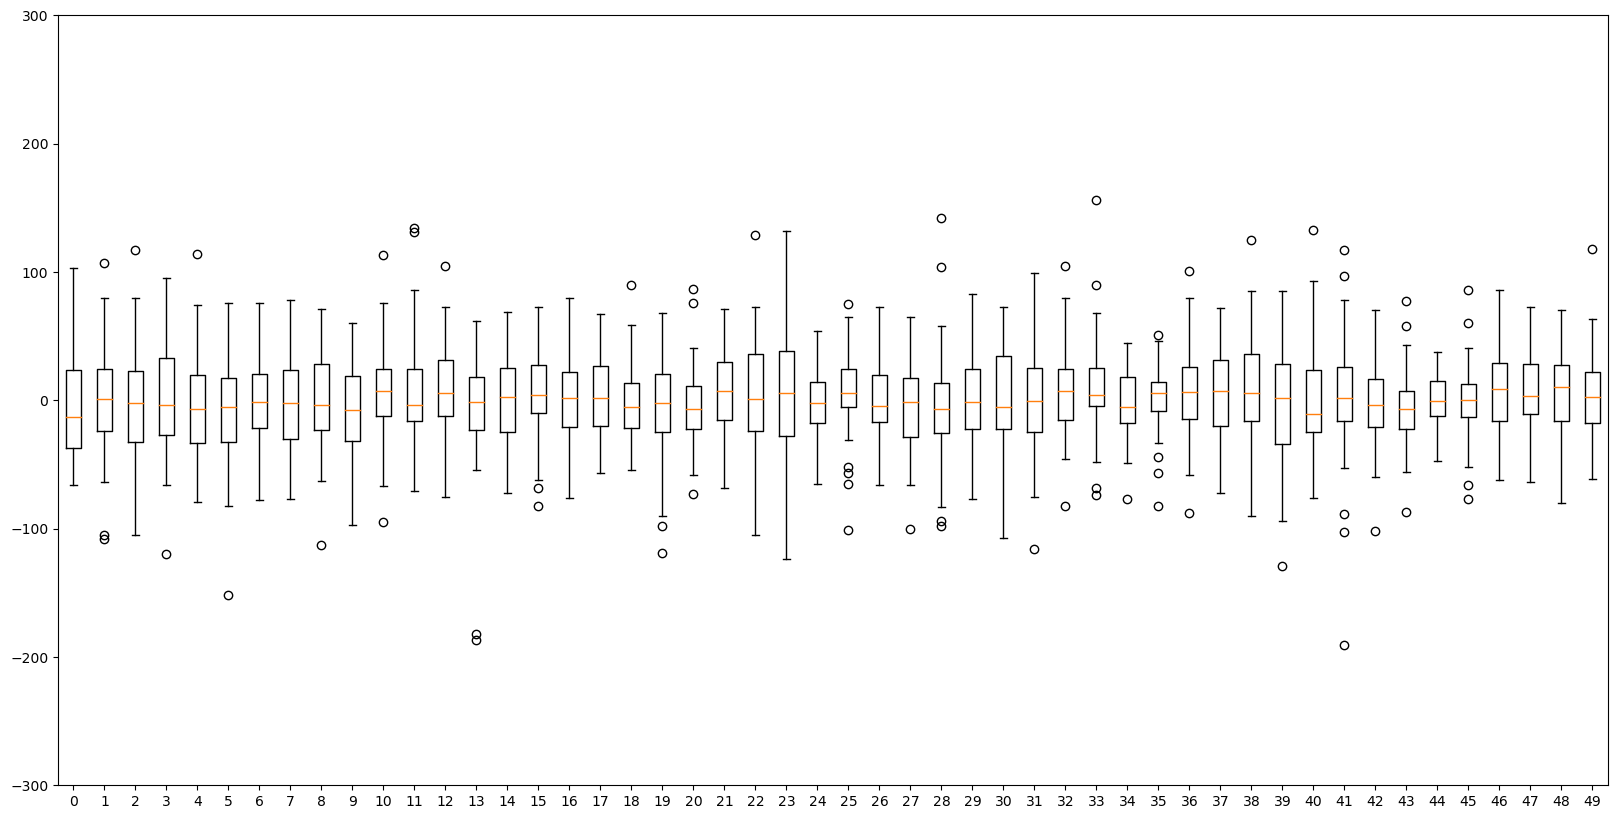

In [47]:
dataPatient = dataTargets.loc[dataTargets['n_user'].isin([7]) & dataTargets['type'].isin([1]) & dataTargets['n_exp'].isin([1])].iloc[0]
fig, ax = plt.subplots()

if dataPatient.target == 1:
    colorLine = 'red'
else:
    colorLine = 'blue'

ysTotal = dataPatient.signal[10*60*200:-3*60*200:2000]
stepSize = len(ysTotal) // 50
ys = []

for i in tqdm(range(50)):
    partData = ysTotal[stepSize*i:stepSize*(i+1)] if i < 49 else ysTotal[stepSize*i:]
    ys.append([j for j in partData if np.abs(j) <= 300])
    
plt.rcParams["figure.figsize"] = (20,10)
ax.set_ylim([-300, 300])
plt.boxplot(ys, positions=range(len(ys)))
plt.show()

# data for Web

In [ ]:
# 4 пациента

# весь период
# Два вида окон - полчаса / час
# Дискретизация - 5 секунд / 10 секунд / 30 секунд / 1 минута / 5 минут

In [ ]:
import datetime
from dateutil.relativedelta import relativedelta

start_datetime = datetime.datetime(2023, 12, 31, 23, 0, 0)
intervalListSeconds = [5, 10, 30, 60, 300]
stepList = [i*200 for i in intervalListSeconds]
patientNumList = [6, 7, 36, 37]

for idPatient in patientNumList:
    dataWeb = pd.DataFrame(columns=['filter', 'time', 'value'])

    for stepSize in stepList:
        dataPatient = (
            dataTargets
                .loc[dataTargets['n_user'].isin([idPatient]) & dataTargets['type'].isin([1]) & dataTargets['n_exp'].isin([1])]
                .iloc[0]
                .signal[10*60*200:-3*60*200]
        )
        iters = len(dataPatient) // stepSize

        valuesList = []
        for i in tqdm(range(iters)):
            valuesList.append([f'{int(stepSize/200)} seconds', start_datetime+relativedelta(seconds=(i+1)*stepSize/200), np.mean(dataPatient[stepSize*i:stepSize*(i+1)])])

        dataWeb = pd.concat([dataWeb, pd.DataFrame(valuesList, columns=['filter', 'time', 'value'])])
        dataWeb.to_csv(f'num_patient_{idPatient}.csv', index=False)

In [70]:
start_datetime = datetime.datetime(2023, 12, 31, 23, 0, 0)
patientNumList = [6, 36]
stepSize = int(10*60*200 / 2000)

for idPatient in patientNumList:
    dataPatient = (
        dataTargets
            .loc[dataTargets['n_user'].isin([idPatient]) & dataTargets['type'].isin([1]) & dataTargets['n_exp'].isin([1])]
            .iloc[0]
            .signal[10*60*200:-3*60*200:2000]
    )
    dataWeb = pd.DataFrame(columns=['time', 'value'])

    iters = int(len(dataPatient) // stepSize)
    valuesList = []

    for i in tqdm(range(iters)):
        partData = [j for j in dataPatient[stepSize*i:stepSize*(i+1)] if np.abs(j) <= 300]

        for item in tqdm(partData):
            valuesList.append([
                start_datetime+relativedelta(seconds=(i+1)*2000*stepSize/200),
                item
            ])
    dataWeb = pd.concat([dataWeb, pd.DataFrame(valuesList, columns=['time', 'value'])])
    dataWeb.to_csv(f'box_plot_num_patient_{idPatient}.csv', index=False)

100%|██████████| 60/60 [00:00<00:00, 202135.13it/s]

100%|██████████| 59/59 [00:00<00:00, 154858.53it/s]

100%|██████████| 60/60 [00:00<00:00, 237189.67it/s]

100%|██████████| 58/58 [00:00<00:00, 172654.10it/s]

100%|██████████| 60/60 [00:00<00:00, 228157.97it/s]

100%|██████████| 59/59 [00:00<00:00, 224355.34it/s]

100%|██████████| 56/56 [00:00<00:00, 231409.88it/s]

100%|██████████| 57/57 [00:00<00:00, 170646.20it/s]

100%|██████████| 60/60 [00:00<00:00, 218074.73it/s]

100%|██████████| 60/60 [00:00<00:00, 177976.12it/s]

100%|██████████| 60/60 [00:00<00:00, 224694.86it/s]

100%|██████████| 60/60 [00:00<00:00, 206108.30it/s]

100%|██████████| 60/60 [00:00<00:00, 233449.20it/s]

100%|██████████| 60/60 [00:00<00:00, 157483.25it/s]

100%|██████████| 59/59 [00:00<00:00, 203506.53it/s]

100%|██████████| 60/60 [00:00<00:00, 225500.22it/s]

100%|██████████| 60/60 [00:00<00:00, 204766.67it/s]

100%|██████████| 60/60 [00:00<00:00, 232586.17it/s]

100%|██████████| 60/60 [00:00<00:00, 198625.29

In [63]:
for i in [6,7,36,37]:
    dataBase.query(f"n_exp == 1 and n_user == {i}")[['age', 'gender', 'height', 'weight']].to_csv(f'base_data_num_patient_{i}.csv', index=False)